 import the libraries and load the dataset:

In [70]:
import zipfile
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

Data loading:

In [44]:
col_names = ['text','sentiment', 'source']

df_amazon = pd.read_csv("amazon_cells_labelled.txt", sep='\t', header=None, names=col_names)
df_imdb   = pd.read_csv("imdb_labelled.txt", sep='\t', header=None, names=col_names)
df_yelp   = pd.read_csv("yelp_labelled.txt", sep='\t', header=None, names=col_names)

df_amazon['source'] = 'Amazon'
df_imdb['source']   = 'IMDb'
df_yelp['source']   = 'Yelp'

df = pd.concat([df_amazon, df_imdb, df_yelp], ignore_index=True)

Exploratory Data Analysis (EDA)

In [45]:
df.head()

,text,sentiment,source
0,So there is no way for me to plug it in here i...,0,Amazon
1,"Good case, Excellent value.",1,Amazon
2,Great for the jawbone.,1,Amazon
3,Tied to charger for conversations lasting more...,0,Amazon
4,The mic is great.,1,Amazon


In [46]:
# dataframe shape:
df.shape

(2748, 3)

In [47]:
#Check Class Distribution (1 = Positive, 0 = Negative)
print(df['sentiment'].value_counts())

sentiment
1    1386
0    1362
Name: count, dtype: int64


In [49]:
#Check Source Distribution
print(df['source'].value_counts())

source
Amazon    1000
Yelp      1000
IMDb       748
Name: count, dtype: int64


In [48]:
#View a random sample to see what real reviews look like
sample = df.sample(1).iloc[0]
print(f"Source: {sample['source']}")
print(f"Label: {sample['sentiment']}") #(1 = Positive, 0 = Negative)
print(f"Text: \"{sample['text']}\"")

Source: Yelp
Label: 0
Text: "Strike 2, who wants to be rushed."


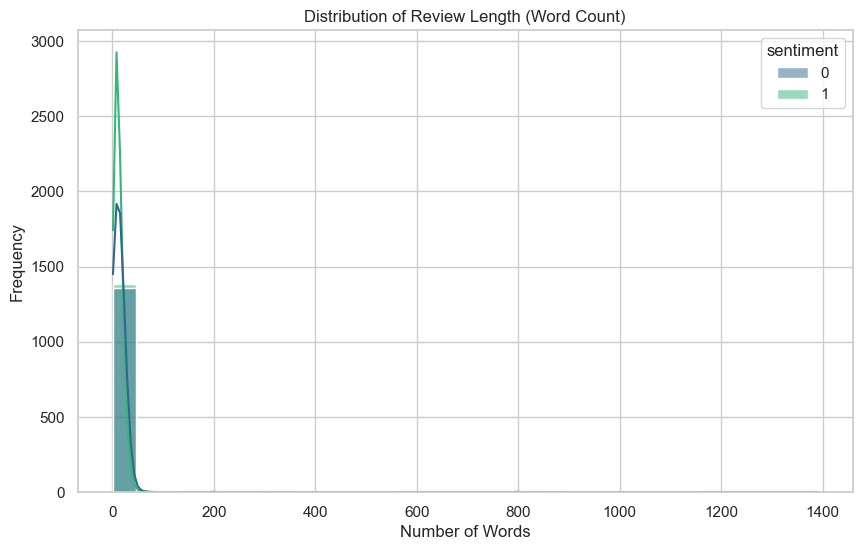

In [50]:
#Visualize Word Count Distribution
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
# Set up the visual style
sns.set(style="whitegrid")

# Create a single figure container
plt.figure(figsize=(10, 6))

# Plot: Review Length Distribution by Sentiment
sns.histplot(data=df, x='word_count', hue='sentiment', kde=True, bins=30, palette='viridis')

plt.title('Distribution of Review Length (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.show()

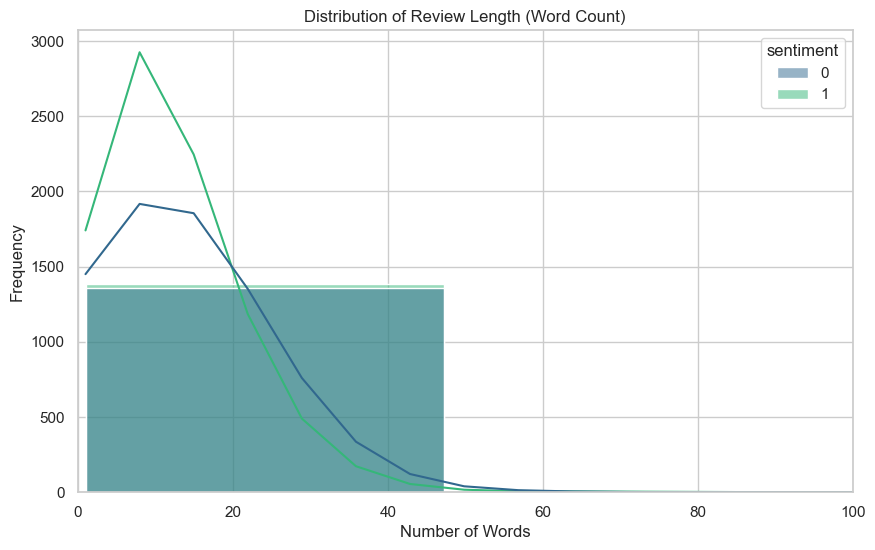

In [51]:
# Set up the visual style
sns.set(style="whitegrid")

# Create a single figure container
plt.figure(figsize=(10, 6))

# Plot: Review Length Distribution by Sentiment
sns.histplot(data=df, x='word_count', hue='sentiment', kde=True, bins=30, palette='viridis')

# Force the X-axis to show only 0 to 100
plt.xlim(0, 100)

plt.title('Distribution of Review Length (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.show()

massive spike on the far left (0–30 words) for both sentiments. This confirms that this specific dataset is made up of short, punchy sentences rather than long, essay-style reviews. This tells you that your machine learning model will have to rely entirely on word choice (vocabulary) rather than the length of the text to make decisions.

Train/Test Split

In [53]:
X = df['text']
y = df['sentiment']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [54]:
print(f"X_train shape: {X_train_raw.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test_raw.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2198,)
y_train shape: (2198,)
X_test shape: (550,)
y_test shape: (550,)


In [55]:
X_train_raw.head()

1679    I do not know if this was Emilio Estevez's dir...
856                                     Poor Reliability.
2381    High-quality chicken on the chicken Caesar salad.
888     Don't trust their website and don't expect any...
241               the phone was unusable and was not new.
Name: text, dtype: object

In [56]:
y_train.head()

1679    1
856     0
2381    1
888     0
241     0
Name: sentiment, dtype: int64

=========================================================

Preprocessing configuration:

identify domain_noise words

In [57]:
from collections import Counter

# Temporary helper to tokenize without custom domain noise
def basic_clean(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text.split()

# Separate raw text by sentiment
pos_text = " ".join(df[df['sentiment'] == 1]['text'])
neg_text = " ".join(df[df['sentiment'] == 0]['text'])

# Tokenize and remove ONLY standard English stopwords
standard_stops = set(stopwords.words('english'))

pos_words = [w for w in basic_clean(pos_text) if w not in standard_stops]
neg_words = [w for w in basic_clean(neg_text) if w not in standard_stops]

# Get Top 30 for each
pos_freq = Counter(pos_words).most_common(30)
neg_freq = Counter(neg_words).most_common(30)

# Extract just the words
pos_top_words = set([w[0] for w in pos_freq])
neg_top_words = set([w[0] for w in neg_freq])

# Find the Intersection (Words in BOTH lists)
overlap = pos_top_words.intersection(neg_top_words)

print(f"Words appearing in top 30 of BOTH Positive and Negative reviews:\n{overlap}")

Words appearing in top 30 of BOTH Positive and Negative reviews:
{'phone', 'service', 'film', 'really', 'good', 'movie', 'also', 'place', 'one', 'food', 'would', 'even', 'like', 'time', 'ever'}


In [58]:
lemmatizer = WordNetLemmatizer()

# Standard Stopwords
stop_words = set(stopwords.words('english'))

# save negation words
negation_words = {'not', 'no', 'nor', 'never', "don't", "aren't", "couldn't", "didn't", "doesn't", "isn't", "wasn't"}
stop_words = stop_words - negation_words

# Add Domain Specific Noise
domain_noise = {'one','really','film', 'movie', 'phone', 'place', 'food','service','even','also','would'}
stop_words.update(domain_noise)

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)
    # 4. Tokenize
    words = text.split()
    # 5. Remove Stopwords & Lemmatize
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return " ".join(cleaned_words)

# Apply preprocessing separately to Train and Test
X_train_clean = X_train_raw.apply(preprocess_text)
X_test_clean = X_test_raw.apply(preprocess_text)

==========================================================

Word clouds:

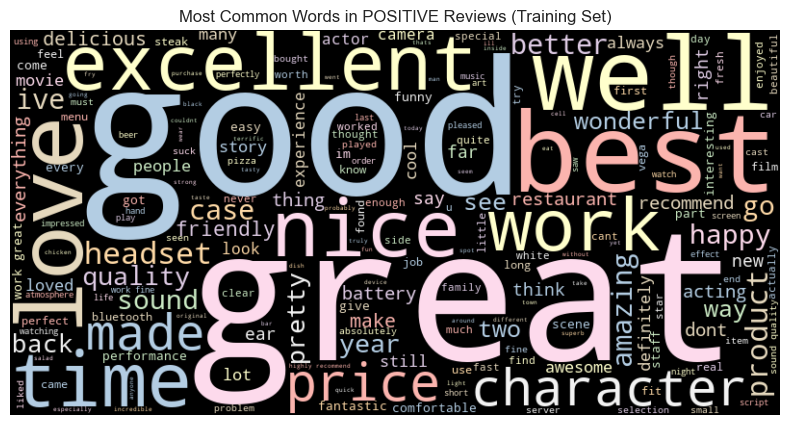

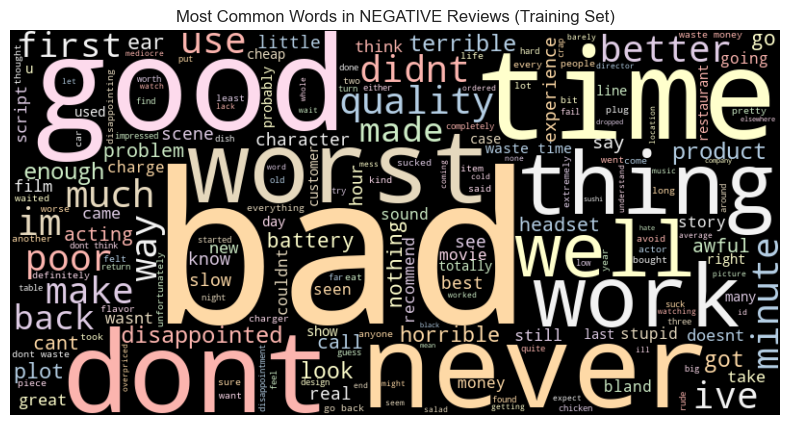

In [64]:
# Only look at Training data for word clouds to avoid peeking at test data
train_df = pd.DataFrame({'cleaned_text': X_train_clean, 'sentiment': y_train})

# Positive Word Cloud
pos_text_clean = " ".join(train_df[train_df['sentiment'] == 1]['cleaned_text'])
wc_pos = WordCloud(width=800, height=400, background_color='black', colormap='Pastel1').generate(pos_text_clean)

plt.figure(figsize=(10, 5))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in POSITIVE Reviews (Training Set)")
plt.show()

# Negative Word Cloud
neg_text_clean = " ".join(train_df[train_df['sentiment'] == 0]['cleaned_text'])
wc_neg = WordCloud(width=800, height=400, background_color='black', colormap='Pastel1').generate(neg_text_clean)

plt.figure(figsize=(10, 5))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in NEGATIVE Reviews (Training Set)")
plt.show()

========================================================

Feature Extraction (TF-IDF Vectorization)

In [65]:
# ngram_range=(1,2)
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit on training data only
X_train_vec = tfidf.fit_transform(X_train_clean)

# transform Test data (using the vocabulary learned from training)
X_test_vec = tfidf.transform(X_test_clean)

print(f"Training Matrix Shape: {X_train_vec.shape}")
print(f"Testing Matrix Shape:  {X_test_vec.shape}")

Training Matrix Shape: (2198, 5000)
Testing Matrix Shape:  (550, 5000)


======================================================

Model Training & Evaluation


Model Accuracy: 81.09%

Classification Report:
              precision    recall  f1-score   support

Negative (0)       0.79      0.84      0.82       273
Positive (1)       0.83      0.78      0.81       277

    accuracy                           0.81       550
   macro avg       0.81      0.81      0.81       550
weighted avg       0.81      0.81      0.81       550



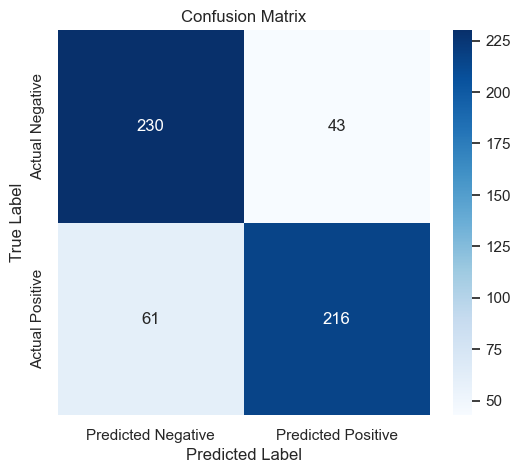

In [66]:
# Initialize the Model
model = LogisticRegression(solver='liblinear', random_state=42)

# Train the Model
model.fit(X_train_vec, y_train)

# Make Predictions on the Test Set
y_pred = model.predict(X_test_vec)

#Evaluate Performance
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

#Visualize the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

======================================================

Feature Importance Analysis:

C:\Users\Green\AppData\Local\Temp\ipykernel_26468\2800386072.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative, y='Feature', x='Coefficient', ax=axes[0], palette='Reds_r')
C:\Users\Green\AppData\Local\Temp\ipykernel_26468\2800386072.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, y='Feature', x='Coefficient', ax=axes[1], palette='Greens')


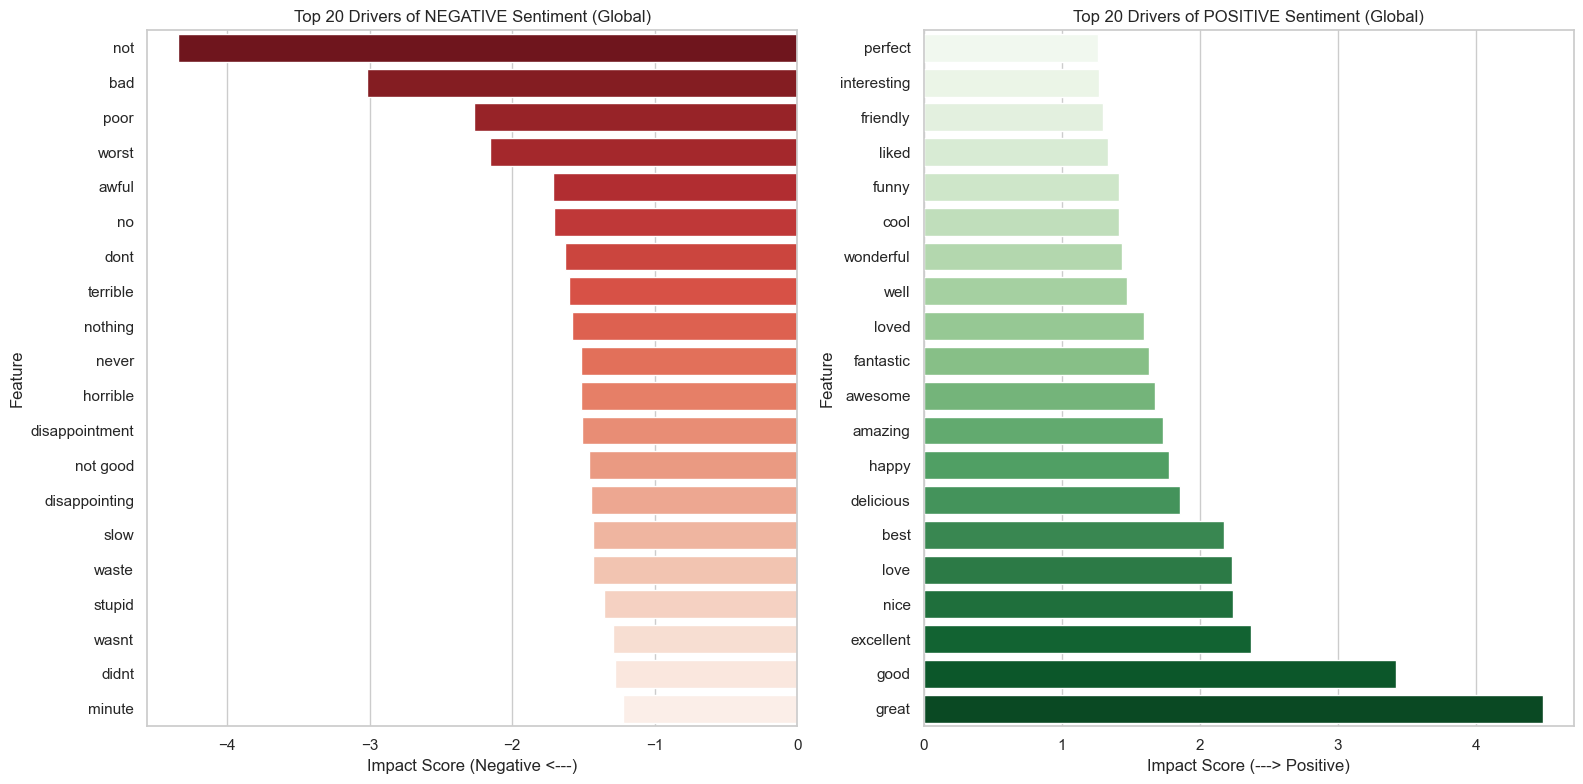

In [67]:
# Apply the preprocessing to the whole dataframe so we can analyze it by source
df['cleaned_text'] = df['text'].apply(preprocess_text)

#Global Feature Importance:

#Get the feature names and coefficients from your trained model
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_.flatten()

# Combine into a DataFrame
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by Coefficient value
top_negative = df_importance.sort_values(by='Coefficient').head(20)
top_positive = df_importance.sort_values(by='Coefficient').tail(20)

# Visualize Global Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Negative
sns.barplot(data=top_negative, y='Feature', x='Coefficient', ax=axes[0], palette='Reds_r')
axes[0].set_title('Top 20 Drivers of NEGATIVE Sentiment (Global)')
axes[0].set_xlabel('Impact Score (Negative <---)')

# Positive
sns.barplot(data=top_positive, y='Feature', x='Coefficient', ax=axes[1], palette='Greens')
axes[1].set_title('Top 20 Drivers of POSITIVE Sentiment (Global)')
axes[1].set_xlabel('Impact Score (---> Positive)')

plt.tight_layout()
plt.show()


Processing Analysis for: Amazon...


C:\Users\Green\AppData\Local\Temp\ipykernel_26468\4229066587.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg, y='feature', x='coef', ax=axes[0], palette='Reds_r')
C:\Users\Green\AppData\Local\Temp\ipykernel_26468\4229066587.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos, y='feature', x='coef', ax=axes[1], palette='Greens')


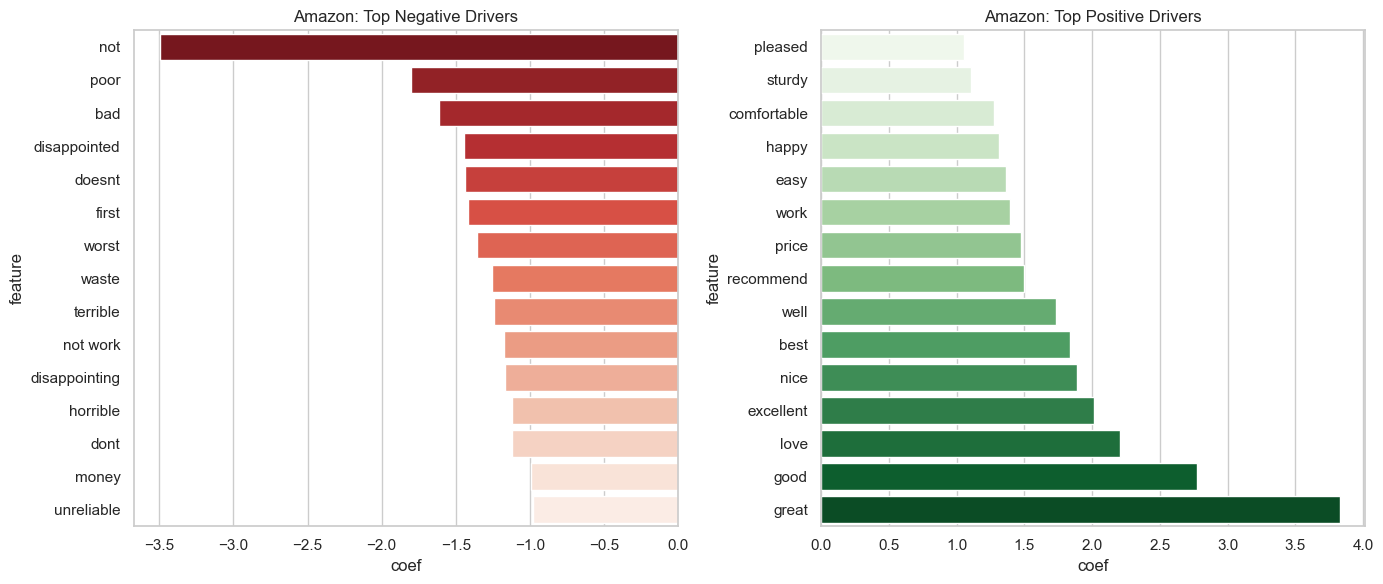


Processing Analysis for: Yelp...


C:\Users\Green\AppData\Local\Temp\ipykernel_26468\4229066587.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg, y='feature', x='coef', ax=axes[0], palette='Reds_r')
C:\Users\Green\AppData\Local\Temp\ipykernel_26468\4229066587.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos, y='feature', x='coef', ax=axes[1], palette='Greens')


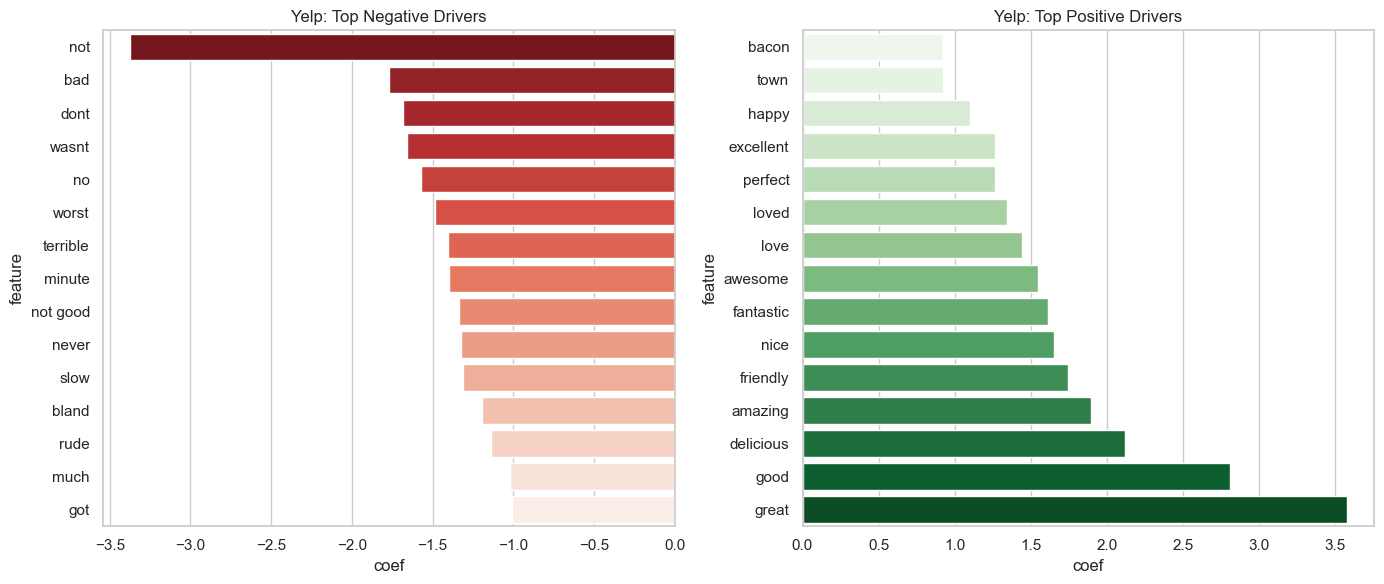


Processing Analysis for: IMDb...


C:\Users\Green\AppData\Local\Temp\ipykernel_26468\4229066587.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg, y='feature', x='coef', ax=axes[0], palette='Reds_r')
C:\Users\Green\AppData\Local\Temp\ipykernel_26468\4229066587.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos, y='feature', x='coef', ax=axes[1], palette='Greens')


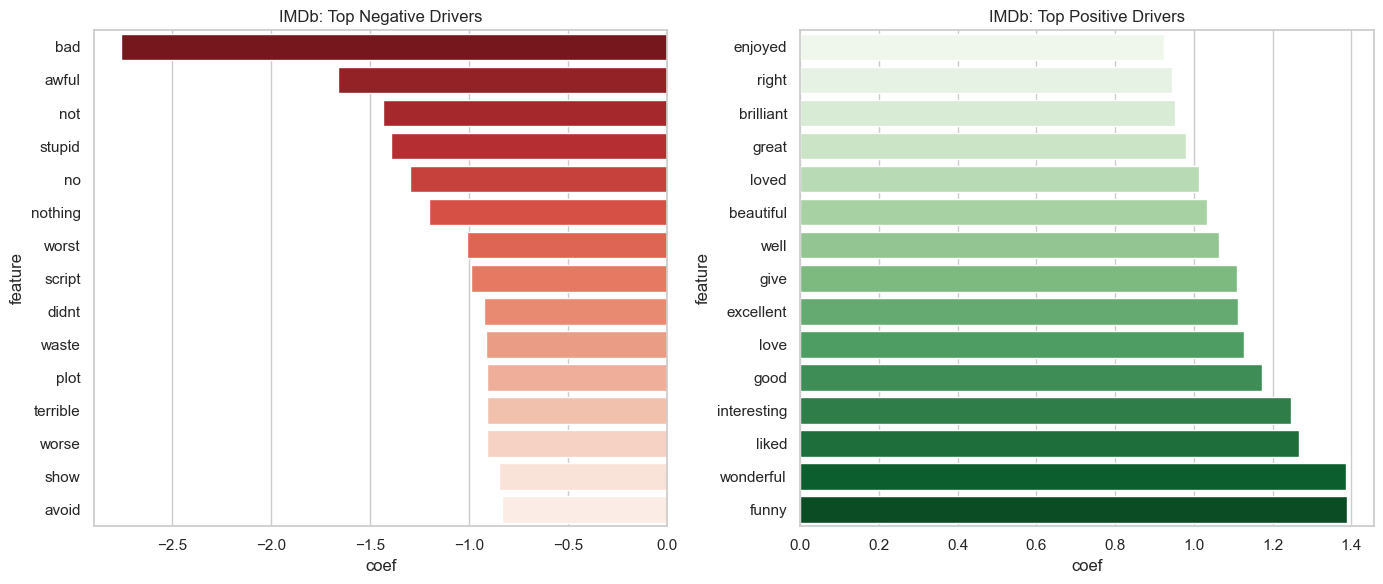

In [68]:
### SOURCE-SPECIFIC ANALYSIS:


sources = ['Amazon', 'Yelp', 'IMDb']

for source in sources:
    print(f"\nProcessing Analysis for: {source}...")

    # Filter Data
    df_subset = df[df['source'] == source]

    # Vectorize this source only
    tfidf_sub = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)

    X_sub = tfidf_sub.fit_transform(df_subset['cleaned_text'])
    y_sub = df_subset['sentiment']

    #Train a small temporary model just for interpretation
    sub_model = LogisticRegression(solver='liblinear', random_state=42)
    sub_model.fit(X_sub, y_sub)

    #Extract Coefficients
    sub_names = tfidf_sub.get_feature_names_out()
    sub_coefs = sub_model.coef_.flatten()

    df_sub_feats = pd.DataFrame({'feature': sub_names, 'coef': sub_coefs})
    df_sub_sorted = df_sub_feats.sort_values(by='coef')

    top_neg = df_sub_sorted.head(15)
    top_pos = df_sub_sorted.tail(15)

    #Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot Negative
    sns.barplot(data=top_neg, y='feature', x='coef', ax=axes[0], palette='Reds_r')
    axes[0].set_title(f'{source}: Top Negative Drivers')

    # Plot Positive
    sns.barplot(data=top_pos, y='feature', x='coef', ax=axes[1], palette='Greens')
    axes[1].set_title(f'{source}: Top Positive Drivers')

    plt.tight_layout()
    plt.show()